In [43]:
%%time
import sys
!{sys.executable} -m pip install xgboost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 39 ms, sys: 8.14 ms, total: 47.2 ms
Wall time: 2.05 s


In [44]:
%%time
# plot feature importance manually
from numpy import loadtxt
import numpy as np
from xgboost import XGBClassifier
from matplotlib import pyplot
from matplotlib.pyplot import figure

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 41 µs


In [58]:
%%time
import pandas as pd
df = pd.read_csv('numerical_only_small.csv')
print('length', len(dataset))

In [61]:
dataset = df.to_numpy()

X = dataset[:,1:]
y = dataset[:,0]

In [61]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [67]:
%%time
import datetime
print(str(datetime.datetime.now())[:-7])
model = XGBClassifier()
model.fit(X, y)
None

2020-11-30 17:14:58
CPU times: user 595 ms, sys: 27.9 ms, total: 623 ms
Wall time: 169 ms


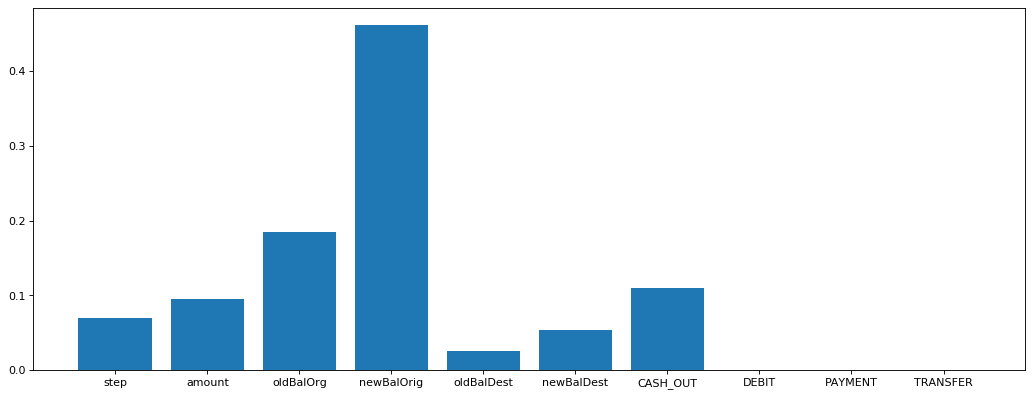

CPU times: user 205 ms, sys: 14 µs, total: 205 ms
Wall time: 204 ms


In [63]:
%%time

fields ='step	amount	oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest	CASH_OUT	DEBIT	PAYMENT	TRANSFER'
fields_arr = fields.split('\t')
fields_arr = [s.replace('balance', 'Bal') for s in fields_arr]
 
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_arr)
        
pyplot.show()